<a href="https://colab.research.google.com/github/KayvanShah1/usc-dsci-552-lab-assignments-hw/blob/main/assignment-6/Kayvan_Shah_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation & Imports

In [5]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.18 s (started: 2023-04-16 03:32:35 +00:00)


In [6]:
import random
import os

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold

import tensorflow
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint

time: 1.28 ms (started: 2023-04-16 03:32:41 +00:00)


# TPU Configuration

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.71.188.34:8470


REPLICAS:  8
time: 53.2 s (started: 2023-04-16 03:32:41 +00:00)


# Helper Functions

In [8]:
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

time: 730 µs (started: 2023-04-16 03:33:35 +00:00)


# Load Dataset

In [9]:
# Load the CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split the full training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# Scale the Dataset
x_train, x_val, x_test = x_train / 255., x_val / 255., x_test / 255.

170498071/170498071 [==============================] - 2s 0us/step
time: 6.51 s (started: 2023-04-16 03:33:42 +00:00)


# Exploratory Data Analysis

In [10]:
print("Train size:", x_train.shape)
print("Validation size:", x_val.shape)
print("Test size:", x_test.shape)

Train size: (40000, 32, 32, 3)
Validation size: (10000, 32, 32, 3)
Test size: (10000, 32, 32, 3)
time: 4.38 ms (started: 2023-04-16 03:33:49 +00:00)


In [11]:
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
]
class_dict = {index: name for index, name in enumerate(class_names)}

time: 753 µs (started: 2023-04-16 03:33:49 +00:00)


In [12]:
def plot_cifar_data(num_row = 3, num_col = 5):
    # get a segment of the dataset
    num = num_row*num_col
    images = x_train[:num]
    labels = y_train.flatten()
    labels = labels[:num]

    # plot images
    fig, axes = plt.subplots(
        num_row, num_col, figsize=(1.25*num_col, 1.25*num_row)
    )
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i])
        ax.set_title('Label: {}'.format(class_names[labels[i]]), fontsize=8)
    plt.tight_layout()
    plt.show()

time: 1.09 ms (started: 2023-04-16 03:33:49 +00:00)


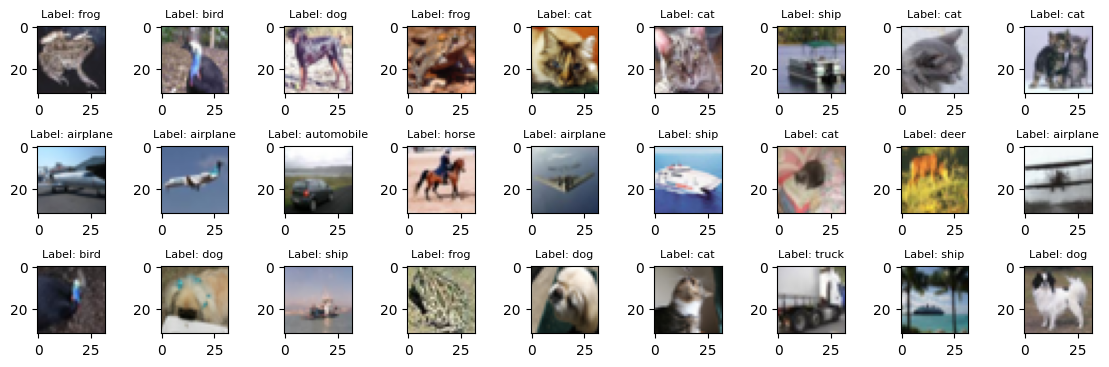

time: 3.85 s (started: 2023-04-16 03:33:50 +00:00)


In [13]:
plot_cifar_data(num_row = 3, num_col = 9)

<Axes: xlabel='counts', ylabel='labels'>

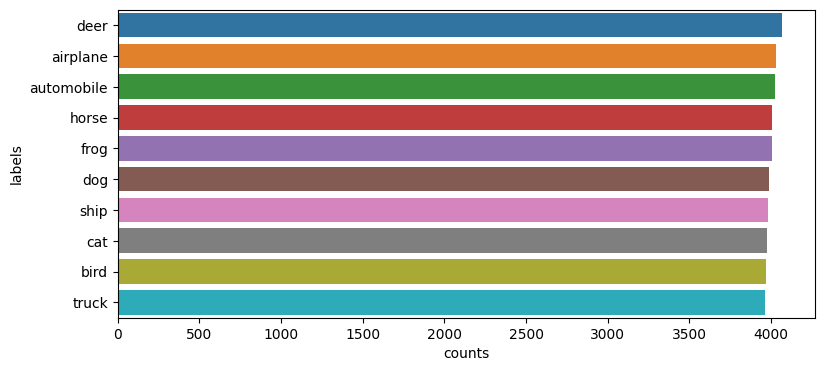

time: 463 ms (started: 2023-04-16 03:33:58 +00:00)


In [14]:
df = pd.DataFrame(
    pd.DataFrame(y_train, columns=["labels"]).value_counts(), columns=["counts"] 
).reset_index()
df["labels"] = df["labels"].apply(lambda x: class_dict[x])

plt.figure(figsize=(9,4))
sns.barplot(df, y="labels", x="counts", orient="h")

# Data Preparation

In [15]:
num_classes = len(class_names)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

time: 2.85 ms (started: 2023-04-16 03:34:01 +00:00)


## Convert to TensorFlow Dataset

In [16]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

time: 1.14 ms (started: 2023-04-16 03:34:02 +00:00)


In [17]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .shuffle(64)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

time: 17.1 s (started: 2023-04-16 03:34:03 +00:00)


# Build & Train Model

## Model Definition

In [23]:
def create_model():
    model = tf.keras.Sequential([
        # First convolutional layer with 32 filters and (3, 3) kernel size
        tf.keras.layers.Conv2D(
            32, (3, 3), activation='relu', 
            input_shape=(32, 32, 3)
        ),
        tf.keras.layers.Dropout(0.25),

        # Second convolutional layer with 32 filters and (3, 3) kernel size
        tf.keras.layers.Conv2D(32, (3, 3), activation='swish'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Third convolutional layer with 64 filters and (3, 3) kernel size
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Flatten the output of the conv layers
        tf.keras.layers.Flatten(),

        # First dense layer with 256 units
        tf.keras.layers.Dense(256, activation='swish'),
        tf.keras.layers.Dropout(0.5),

        # Output layer with 10 units and softmax activation
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model with the sparse_categorical_accuracy loss function and the adam optimizer
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(), 
        metrics=[tf.keras.metrics.categorical_accuracy]
    )
    
    return model

time: 1.3 ms (started: 2023-04-16 03:36:16 +00:00)


## Build Model

In [24]:
# Clear backend sessions to reset name counters
tf.keras.backend.clear_session()

with strategy.scope():
    model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                        

## Train Model

In [25]:
EPOCHS = 50

n_steps = x_train.shape[0] // BATCH_SIZE

time: 614 µs (started: 2023-04-16 03:36:23 +00:00)


In [26]:
%%time
# Define the checkpoint callback to save the best model
# filepath = f'model-cifar-10-cnn.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Fit the model on data
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    # callbacks=[checkpoint]
)

Epoch 1/50
312/312 [==============================] - 18s 45ms/step - loss: 1.7001 - categorical_accuracy: 0.3801 - val_loss: 1.3853 - val_categorical_accuracy: 0.5044
Epoch 2/50
312/312 [==============================] - 10s 31ms/step - loss: 1.3497 - categorical_accuracy: 0.5176 - val_loss: 1.2145 - val_categorical_accuracy: 0.5695
Epoch 3/50
312/312 [==============================] - 10s 33ms/step - loss: 1.1944 - categorical_accuracy: 0.5776 - val_loss: 1.0805 - val_categorical_accuracy: 0.6211
Epoch 4/50
312/312 [==============================] - 10s 31ms/step - loss: 1.0964 - categorical_accuracy: 0.6127 - val_loss: 1.0231 - val_categorical_accuracy: 0.6361
Epoch 5/50
312/312 [==============================] - 10s 31ms/step - loss: 1.0229 - categorical_accuracy: 0.6380 - val_loss: 0.9590 - val_categorical_accuracy: 0.6554
Epoch 6/50
312/312 [==============================] - 10s 32ms/step - loss: 0.9701 - categorical_accuracy: 0.6603 - val_loss: 0.8844 - val_categorical_accuracy:

# Evaluate Model

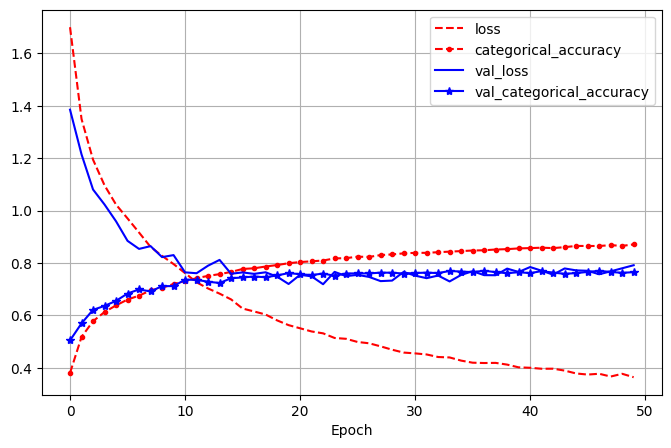

time: 326 ms (started: 2023-04-16 03:44:50 +00:00)


In [27]:
pd.DataFrame(train_history.history).plot(
    figsize=(8, 5), 
    # ylim=[0.29, 0.9], 
    grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.show()

In [28]:
model.evaluate(test_dataset)

79/79 [==============================] - 4s 23ms/step - loss: 0.8068 - categorical_accuracy: 0.7615


[0.8067952990531921, 0.7615000009536743]

time: 3.85 s (started: 2023-04-16 03:45:04 +00:00)


In [33]:
y_pred = model.predict(test_dataset)
y_pred = y_pred.argmax(axis=-1)

print(classification_report(y_test.argmax(axis=-1), y_pred, target_names=class_names))

79/79 [==============================] - 3s 18ms/step
              precision    recall  f1-score   support

    airplane       0.77      0.78      0.77      1000
  automobile       0.86      0.88      0.87      1000
        bird       0.66      0.69      0.67      1000
         cat       0.59      0.56      0.58      1000
        deer       0.73      0.73      0.73      1000
         dog       0.68      0.66      0.67      1000
        frog       0.85      0.82      0.84      1000
       horse       0.80      0.81      0.80      1000
        ship       0.78      0.90      0.83      1000
       truck       0.91      0.78      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

time: 3.33 s (started: 2023-04-16 03:46:04 +00:00)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')])

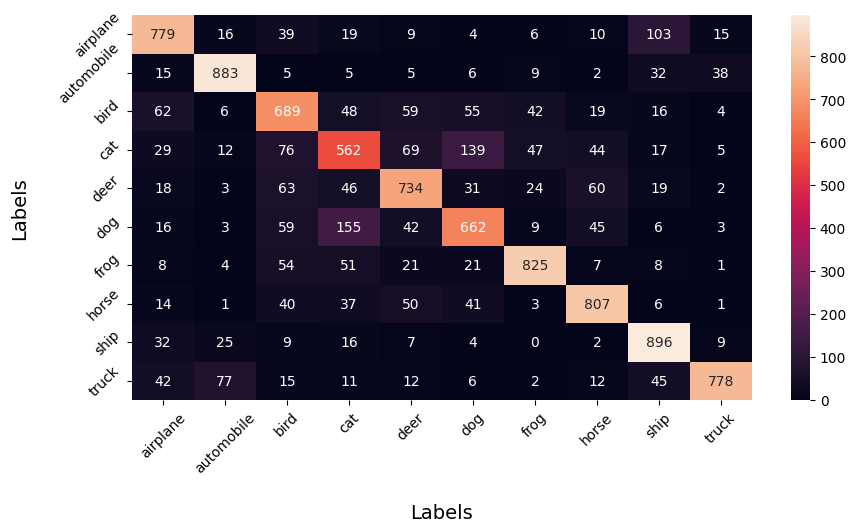

time: 912 ms (started: 2023-04-16 03:59:33 +00:00)


In [52]:
from sklearn.metrics import confusion_matrix

dfm = confusion_matrix(y_test.argmax(axis=-1), y_pred)

plt.figure(figsize=(10,5))
ax = sns.heatmap(dfm, annot=True, fmt='d')

# set x-axis label and ticks. 
ax.set_xlabel("Labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(class_names)
plt.xticks(rotation = 45)

# set y-axis label and ticks
ax.set_ylabel("Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(class_names)
plt.yticks(rotation = 45)